<a href="https://colab.research.google.com/github/RavinduP/Product_Success/blob/Market_demand_forecasting/xgbosstimbalance1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First 5 rows of the dataset:
  Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0   2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1   2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2   2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3   2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4   2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   

                   Size  QTY(EA)  
0  Multy Purpose Ladder        1  
1           STEP LADDER        1  
2           STEP LADDER        1  
3           STEP LADDER        1  
4           STEP LADDER        1  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7660 entries, 0 to 7659
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Billing Date   7660 non-null   datetime64[ns]
 1   Net Weight  

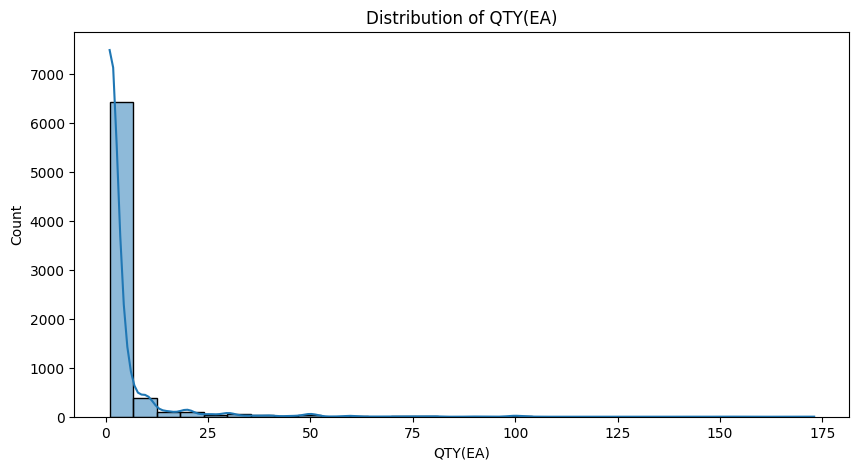

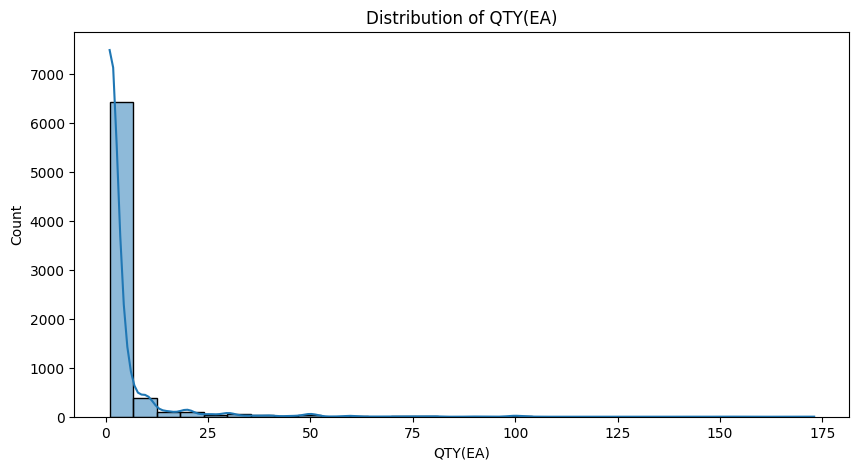

Summary Statistics for QTY(EA):
count    7249.000000
mean        4.040971
std        10.016094
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       173.000000
Name: QTY(EA), dtype: float64

Unique values in QTY(EA):
[  1   3   2   4   5   6  10  25  20  13  11   7  12  45  58   9  30  16
   8  18  24  19  26  15  14 100  50 102  48  67 150 104  65  75  17  59
 141 173  40  70  36  78  22  99  32  28  29 116  80  54  52  90  60  27
  35  39  33  37  46  43  51  56  73 153  23  21  34  31]

95th percentile threshold: 17.0
Number of values above the 95th percentile: 358

Summary Statistics after capping outliers:
count    7249.000000
mean        2.950752
std         4.101994
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        17.000000
Name: QTY(EA), dtype: float64

Number of values above the 95th percentile after capping: 0


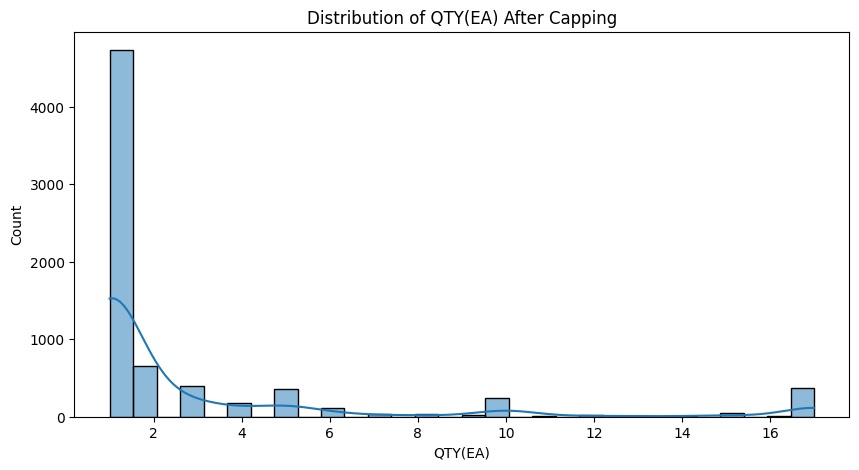


Unique values in QTY(EA):
[ 1  3  2  4  5  6 10 17 13 11  7 12  9 16  8 15 14]
QTY(EA)
1     4733
2      651
3      399
4      182
5      353
6      109
7       39
8       40
9       18
10     241
11      13
12      24
13      14
14      10
15      44
16      10
17     369
Name: count, dtype: int64
QTY(EA)                         int64
Year                            int32
Month                           int32
Day                             int32
Weekday                         int32
Quarter                         int32
Sales Region_Colombo            int64
Sales Region_Direct             int64
Sales Region_East               int64
Sales Region_Exports            int64
Sales Region_Kandy              int64
Sales Region_Key Accounts       int64
Sales Region_Kurunagela         int64
Sales Region_Negombo            int64
Sales Region_North              int64
Sales Region_Projects           int64
Sales Region_Projects Export    int64
Sales Region_Southern           int64
Size_Multy Purp

<ipython-input-1-e0f4c4154d3c>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=qty_counts.index, y=qty_counts.values, palette="viridis")
<ipython-input-1-e0f4c4154d3c>:160: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       0
3       0
4       0
       ..
7648    0
7649    0
7650    0
7651    0
7652    0
Name: Sales Region_Colombo, Length: 7249, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:, 6:] = df.iloc[:, 6:].astype(int)
<ipython-input-1-e0f4c4154d3c>:160: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       0
3       0
4       0
       ..
7648    0
7649    0
7650    0
7651    0
7

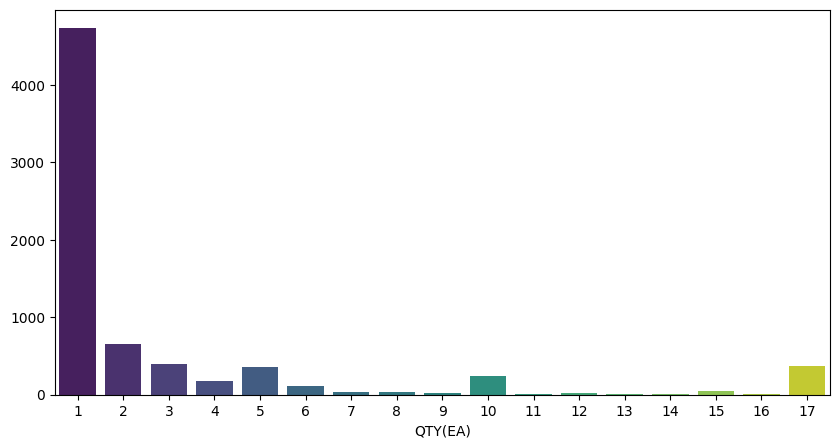

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
# Load the dataset
file_path = 'Ladders updated data.xlsx'
data = pd.ExcelFile(file_path)

# Load the 'Data' sheet
df = data.parse('Data')

# Display the first few rows to understand the structure
print("First 5 rows of the dataset:")
print(df.head())

# Check basic information about the dataset
print("\nDataset Information:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())
# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check unique values in categorical columns
categorical_cols = ['Sales Region', 'Material Code', 'Size', 'QTY(EA)']
for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(df[col].unique())


# Drop unnecessary columns
df = df.drop(columns=["Net Weight", "Invoice Value","Material Code"]) # Removed 'Material Code' from the list
print(df.head())
df = df[df['QTY(EA)'] > 0]
print(df.head())
categorical_cols = ['QTY(EA)']
for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(df[col].unique())
# Extract time-based features
df['Year'] = df['Billing Date'].dt.year
df['Month'] = df['Billing Date'].dt.month
df['Day'] = df['Billing Date'].dt.day
df['Weekday'] = df['Billing Date'].dt.weekday
df['Quarter'] = df['Billing Date'].dt.quarter

# Display updated dataset
print("\nDataset after adding time-based features:")
print(df.head())

# Drop the original date column
df = df.drop(columns=["Billing Date"])
print(df.head())

# Map region codes to region names
region_mapping = {
    "R1": "North", "R2": "Kandy", "R3": "Kurunagela", "R4": "Southern", "R5": "Negombo",
    "R6": "East", "R7": "Colombo", "R8": "Key Accounts", "PR": "Projects", "PR-EX": "Projects Export",
    "EX": "Exports", "DR": "Direct"
}

# Replace Sales Region codes with actual names
df["Sales Region"] = df["Sales Region"].replace(region_mapping)

# Verify changes
print(df["Sales Region"].unique())
print(df.isnull().sum())  # Check if any column has missing values

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['QTY(EA)'].quantile(0.25)
Q3 = df['QTY(EA)'].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = df[(df['QTY(EA)'] < lower_bound) | (df['QTY(EA)'] > upper_bound)]
num_outliers = outliers.shape[0]

print(f"Number of outliers in QTY(EA): {num_outliers}")
print(outliers.sort_values(by='QTY(EA)', ascending=False).head(10))  # Highest outliers
print(outliers.sort_values(by='QTY(EA)', ascending=True).head(10))   # Lowest outliers
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df['QTY(EA)'], bins=30, kde=True)
plt.title("Distribution of QTY(EA)")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['QTY(EA)'], bins=30, kde=True)
plt.title("Distribution of QTY(EA)")
plt.show()

# Get basic stats of QTY(EA)
print("Summary Statistics for QTY(EA):")
print(df['QTY(EA)'].describe())

# Checking for unique values, especially the higher peaks
print("\nUnique values in QTY(EA):")
print(df['QTY(EA)'].unique())

# Checking the number of outliers (values above 95th percentile)
upper_limit = df['QTY(EA)'].quantile(0.95)
print(f"\n95th percentile threshold: {upper_limit}")
print(f"Number of values above the 95th percentile: {len(df[df['QTY(EA)'] > upper_limit])}")

# Cap values above the 95th percentile (17)
df['QTY(EA)'] = df['QTY(EA)'].clip(upper=17)

# Print summary statistics after capping
print("\nSummary Statistics after capping outliers:")
print(df['QTY(EA)'].describe())

# Check how many values are above the 95th percentile after capping
print(f"\nNumber of values above the 95th percentile after capping: {len(df[df['QTY(EA)'] > 17])}")


# Plot the updated distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['QTY(EA)'], bins=30, kde=True)
plt.title("Distribution of QTY(EA) After Capping")
plt.show()
# Checking for unique values, especially the higher peaks
print("\nUnique values in QTY(EA):")
print(df['QTY(EA)'].unique())
import matplotlib.pyplot as plt
import seaborn as sns

# Count frequency of each unique value in QTY(EA)
qty_counts = df["QTY(EA)"].value_counts().sort_index()

# Print counts
print(qty_counts)

plt.figure(figsize=(10,5))
sns.barplot(x=qty_counts.index, y=qty_counts.values, palette="viridis")


# Perform One-Hot Encoding for Sales Region and Size
df = pd.get_dummies(df, columns=["Sales Region", "Size"], drop_first=False)
# Convert boolean columns to integer (0 and 1)
df.iloc[:, 6:] = df.iloc[:, 6:].astype(int)

# Verify conversion
print(df.dtypes)
# Verify dataset
print(df.head())
print(df.info())


import pandas as pd
# Add lag features
df['QTY(EA)_lag1'] = df['QTY(EA)'].shift(1)   # Lag 1: Previous day sales
df['QTY(EA)_lag7'] = df['QTY(EA)'].shift(7)   # Lag 7: Sales from 7 days ago
df['QTY(EA)_lag30'] = df['QTY(EA)'].shift(30) # Lag 30: Sales from 30 days ago

# Add rolling statistics
df['QTY(EA)_rolling_mean_7'] = df['QTY(EA)'].rolling(window=7).mean()  # 7-day rolling mean
df['QTY(EA)_rolling_sum_7'] = df['QTY(EA)'].rolling(window=7).sum()    # 7-day rolling sum
# Display the dataframe to see the lag features
print(df)
df.fillna(method='ffill', inplace=True)   # Replace NaN values with 0
print(df)
# Import necessary libraries
from sklearn.preprocessing import StandardScaler

# Define your numerical features to scale
numerical_features = ['QTY(EA)_lag1', 'QTY(EA)_lag7', 'QTY(EA)_lag30',
                      'QTY(EA)_rolling_mean_7', 'QTY(EA)_rolling_sum_7']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features to scale them
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the first few rows of the scaled data
print(df.head())
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Assuming df is your dataframe
df = df.drop(['Weekday', 'Quarter'], axis=1)  # Dropping unnecessary columns

# Handle missing values for lag features (Impute with the previous value or mean)
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies if needed
df[['QTY(EA)_lag1', 'QTY(EA)_lag7', 'QTY(EA)_lag30', 'QTY(EA)_rolling_mean_7', 'QTY(EA)_rolling_sum_7']] = imputer.fit_transform(df[['QTY(EA)_lag1', 'QTY(EA)_lag7', 'QTY(EA)_lag30', 'QTY(EA)_rolling_mean_7', 'QTY(EA)_rolling_sum_7']])

# If you want to apply scaling (for other models):
numerical_features = ['QTY(EA)_lag1', 'QTY(EA)_lag7', 'QTY(EA)_lag30', 'QTY(EA)_rolling_mean_7', 'QTY(EA)_rolling_sum_7']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])



In [2]:
print(df.head())

   QTY(EA)  Year  Month  Day  Sales Region_Colombo  Sales Region_Direct  \
0        1  2023      2    8                     0                    0   
1        1  2022      9   22                     0                    0   
2        1  2022      9   22                     0                    0   
3        1  2022      9   22                     0                    0   
4        1  2022     10   16                     0                    0   

   Sales Region_East  Sales Region_Exports  Sales Region_Kandy  \
0                  0                     1                   0   
1                  0                     0                   1   
2                  0                     0                   1   
3                  0                     0                   1   
4                  0                     0                   1   

   Sales Region_Key Accounts  ...  Sales Region_Projects  \
0                          0  ...                      0   
1                          0  ..

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7249 entries, 0 to 7652
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   QTY(EA)                       7249 non-null   int64  
 1   Year                          7249 non-null   int32  
 2   Month                         7249 non-null   int32  
 3   Day                           7249 non-null   int32  
 4   Sales Region_Colombo          7249 non-null   int64  
 5   Sales Region_Direct           7249 non-null   int64  
 6   Sales Region_East             7249 non-null   int64  
 7   Sales Region_Exports          7249 non-null   int64  
 8   Sales Region_Kandy            7249 non-null   int64  
 9   Sales Region_Key Accounts     7249 non-null   int64  
 10  Sales Region_Kurunagela       7249 non-null   int64  
 11  Sales Region_Negombo          7249 non-null   int64  
 12  Sales Region_North            7249 non-null   int64  
 13  Sales Re

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Step 1: Define features (X) and target (y)
X = df.drop(columns=['QTY(EA)'])  # All features except the target
y = df['QTY(EA)']  # Target variable

# Step 2: Combine X and y for convenience
df_combined = pd.concat([X, y], axis=1)

# Step 3: Split the data into majority and minority classes
majority_class = df_combined[df_combined['QTY(EA)'] == 1]
minority_class = df_combined[df_combined['QTY(EA)'] != 1]

# Step 4: Perform undersampling on the majority class
# Resample the majority class to match the minority class size
majority_class_downsampled = resample(majority_class,
                                      replace=False,  # Don't replace, just sample without replacement
                                      n_samples=len(minority_class),  # Downsample to the size of minority class
                                      random_state=42)

# Step 5: Combine the downsampled majority class with the minority class
df_balanced = pd.concat([majority_class_downsampled, minority_class])

# Step 6: Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 7: Split the features and target again
X_balanced = df_balanced.drop(columns=['QTY(EA)'])
y_balanced = df_balanced['QTY(EA)']

# Check class distribution after undersampling
print("Class distribution after undersampling:")
print(y_balanced.value_counts())

# You can now use this balanced dataset (X_balanced, y_balanced) for model training.


Class distribution after undersampling:
QTY(EA)
1     2516
2      651
3      399
17     369
5      353
10     241
4      182
6      109
15      44
8       40
7       39
12      24
9       18
13      14
11      13
14      10
16      10
Name: count, dtype: int64


In [5]:
# Split the balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Check shapes of train/test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
from xgboost import XGBRegressor

# Initialize and train the model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on the train and test sets
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate MAE, RMSE, and R² Score for the training set
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

# Calculate MAE, RMSE, and R² Score for the test set
test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

# Display the results in the requested format
print(f"📊 Sales (QTY) - Train Set:")
print(f"✅ MAE: {train_mae:.4f} | ✅ RMSE: {train_rmse:.4f} | ✅ R² Score: {train_r2:.4f}")
print("--------------------------------------------------")
print(f"📊 Sales (QTY) - Test Set:")
print(f"✅ MAE: {test_mae:.4f} | ✅ RMSE: {test_rmse:.4f} | ✅ R² Score: {test_r2:.4f}")



(4025, 22) (1007, 22) (4025,) (1007,)
📊 Sales (QTY) - Train Set:
✅ MAE: 0.4173 | ✅ RMSE: 0.7692 | ✅ R² Score: 0.9730
--------------------------------------------------
📊 Sales (QTY) - Test Set:
✅ MAE: 1.4395 | ✅ RMSE: 2.7646 | ✅ R² Score: 0.6443


In [6]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 500, 50),  # Number of trees in the model
    'max_depth': np.arange(3, 15, 1),  # Maximum depth of the trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate (shrinkage)
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training data
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of features per tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) needed in a child
    'scale_pos_weight': [1, 10, 20],  # Balancing of positive and negative weights
    'reg_alpha': [0, 0.1, 1],  # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 1]  # L2 regularization term on weights
}
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model
xgb = XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Set up the RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=20,  # Number of random combinations to try
    scoring='neg_mean_squared_error', cv=3,  # Cross-validation with 3 folds
    verbose=2, random_state=42, n_jobs=-1  # Print progress, use multiple CPU cores
)

# Fit the model
random_search.fit(X_train, y_train)
print(f"Best Hyperparameters: {random_search.best_params_}")
best_xgb = random_search.best_estimator_

# Train the model
best_xgb.fit(X_train, y_train)

# Make predictions
y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"📊 Sales (QTY) - Train Set:")
print(f"✅ MAE: {train_mae:.4f} | ✅ RMSE: {train_rmse:.4f} | ✅ R² Score: {train_r2:.4f}")
print("--------------------------------------------------")
print(f"📊 Sales (QTY) - Test Set:")
print(f"✅ MAE: {test_mae:.4f} | ✅ RMSE: {test_rmse:.4f} | ✅ R² Score: {test_r2:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': np.int64(400), 'min_child_weight': 3, 'max_depth': np.int64(9), 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
📊 Sales (QTY) - Train Set:
✅ MAE: 0.7030 | ✅ RMSE: 1.2709 | ✅ R² Score: 0.9263
--------------------------------------------------
📊 Sales (QTY) - Test Set:
✅ MAE: 1.3945 | ✅ RMSE: 2.6254 | ✅ R² Score: 0.6793
